<a href="https://colab.research.google.com/github/logcow123/Flask-roommates/blob/main/starter_housing_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hdbscan 0.8.41 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
umap-learn 0.5.11 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

In [10]:
#adds neighborhood column
housing["neighborhood"] = housing["id"].astype(str).str[:6]

#adds columns for year, month, day, day of the week
dt = pd.to_datetime(housing["date"], errors="coerce")
housing["year"] = dt.dt.year
housing["month"] = dt.dt.month
housing["day"] = dt.dt.day
housing["dayofweek"] = dt.dt.dayofweek

#adds total_sqft column
housing["total_sqft"] = housing["sqft_above"] + housing["sqft_basement"].fillna(0)


#adds house_age, renovated_flag, reno_age columns
housing["house_age"] = housing["year"] - housing["yr_built"]
housing["renovated_flag"] = (housing["yr_renovated"].fillna(0) > 0).astype(int)
housing["reno_age"] = np.where(
    housing["renovated_flag"] == 1,
    housing["year"] - housing["yr_renovated"],
    0
)

#adds bathrooms_per_bedroom column
housing["bathrooms_per_bedroom"] = housing["bathrooms"] / housing["bedrooms"].replace(0, np.nan)
housing["bathrooms_per_bedroom"] = housing["bathrooms_per_bedroom"].fillna(0)

#should we drop or just drop(clipping is less bias,but more variance)?
# caps extreme square footage values to reduce outlier impact
for col in ["sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "total_sqft"]:
    if col in housing.columns:
        hi = housing[col].quantile(0.995)
        housing[col] = housing[col].clip(upper=hi)

# caps extreme bedroom and bathroom counts
for col, hi in [("bedrooms", 10), ("bathrooms", 7.5)]:
    if col in housing.columns:
        housing[col] = housing[col].clip(upper=hi)

TypeError: Series.drop() got an unexpected keyword argument 'upper'

In [ ]:
housing.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,neighborhood,year,month,day,dayofweek,total_sqft,house_age,renovated_flag,reno_age,bathrooms_per_bedroom
0,1565930130,20141104T000000,4,3.25,3760.0,4675.0,2.0,0,0,3,...,156593,2014,11,4,1,3760.0,7,0,0,0.812500
1,3279000420,20150115T000000,3,1.75,1460.0,7800.0,1.0,0,0,2,...,327900,2015,1,15,3,1460.0,36,0,0,0.583333
2,194000575,20141014T000000,4,1.00,1340.0,5800.0,1.5,0,2,3,...,194000,2014,10,14,1,1340.0,100,0,0,0.250000
3,2115510160,20141208T000000,3,1.75,1440.0,8050.0,1.0,0,0,3,...,211551,2014,12,8,0,1440.0,29,0,0,0.583333
4,7522500005,20140815T000000,2,1.50,1780.0,4750.0,1.0,0,0,4,...,752250,2014,8,15,4,1780.0,67,0,0,0.750000


In [9]:
target_col = "price"
drop_cols = [target_col, "id", "date"]
X = housing.drop(columns=[c for c in drop_cols if c in housing.columns])
y = np.log1p(housing[target_col])

# One-hot encode the 'neighborhood' column
X = pd.get_dummies(X, columns=['neighborhood'], drop_first=True)

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split temp into dev (10%) and test (10%)
X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

model = XGBRegressor(
    n_estimators=2000,        # total number of trees (more trees = more learning capacity, but slower)
    learning_rate=0.03,       # how much each tree contributes (smaller = more gradual learning, usually better generalization)
    max_depth= 8,             # max depth of each tree (controls complexity; deeper = can fit more patterns but risk overfitting)
    subsample=0.8,            # percent of rows used per tree (adds randomness to reduce overfitting)
    colsample_bytree=0.8,     # percent of features used per tree (adds randomness + helps prevent reliance on a few features)
    gamma=0.1,                # minimum loss reduction needed to split a node (higher = fewer splits = less overfitting)
    min_child_weight=10,      # minimum "weight" in a leaf (higher = more conservative splits, helps prevent overfitting)
    reg_alpha=0.0,            # L1 regularization (pushes some feature effects toward 0, can help if too many features)
    reg_lambda=1.0,           # L2 regularization (stabilizes weights, reduces overfitting; default is usually 1)
    random_state=42,          # makes results reproducible (same split/training behavior each run)
    n_jobs=-1                 # uses all CPU cores to train faster
)


# Fit on TRAIN only
model.fit(X_train, y_train)

# Predict on DEV
dev_pred_log = model.predict(X_dev)

# Convert back to dollars
dev_pred_price = np.expm1(dev_pred_log)
y_dev_price = np.expm1(y_dev)

# Metrics on DEV
dev_rmse = root_mean_squared_error(y_dev_price, dev_pred_price)
dev_r2 = r2_score(y_dev_price, dev_pred_price)

print("DEV RMSE (dollars):", dev_rmse)
print("DEV R^2 (dollars):", dev_r2)

KeyboardInterrupt: 

In [8]:
# Final evaluation on TEST (only after tuning is done)
test_pred_log = model.predict(X_test)
test_pred_price = np.expm1(test_pred_log)
y_test_price = np.expm1(y_test)

test_rmse = root_mean_squared_error(y_test_price, test_pred_price)
test_r2 = r2_score(y_test_price, test_pred_price)

print("TEST RMSE (dollars):", test_rmse)
print("TEST R^2 (dollars):", test_r2)

TEST RMSE (dollars): 146305.62359160578
TEST R^2 (dollars): 0.868409968042663


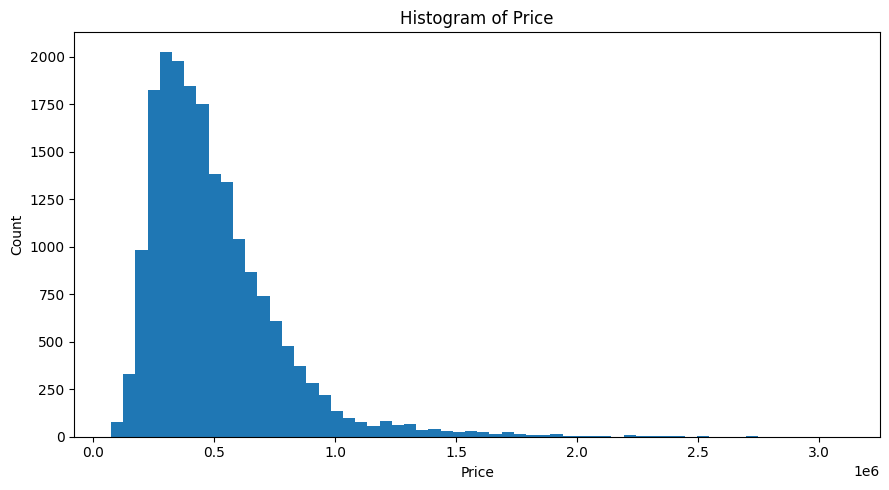

In [ ]:
#histogram of price
plt.figure(figsize=(9, 5))
plt.hist(housing["price"], bins=60)
plt.title("Histogram of Price")
plt.xlabel("Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


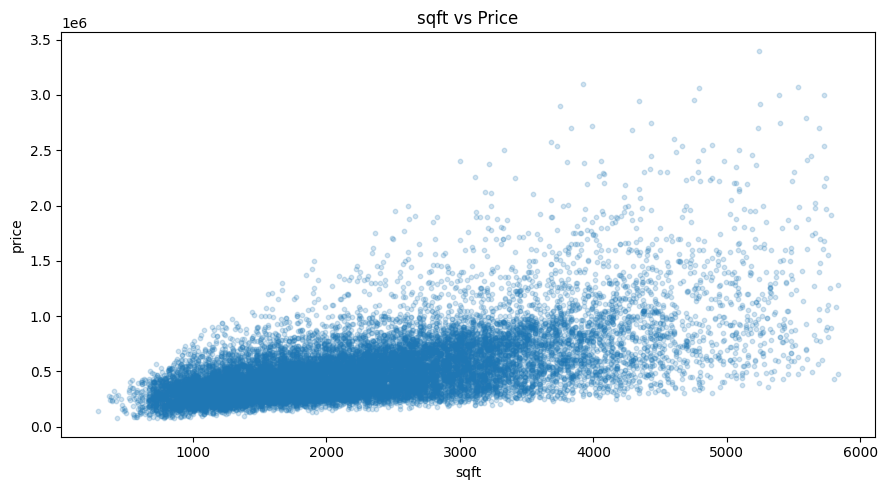

In [ ]:
#various scatter plots
plt.figure(figsize=(9, 5))
plt.scatter(housing["total_sqft"], housing["price"], alpha=0.2, s=10)
plt.title("sqft vs Price")
plt.xlabel("sqft")
plt.ylabel("price")
plt.tight_layout()
plt.show()

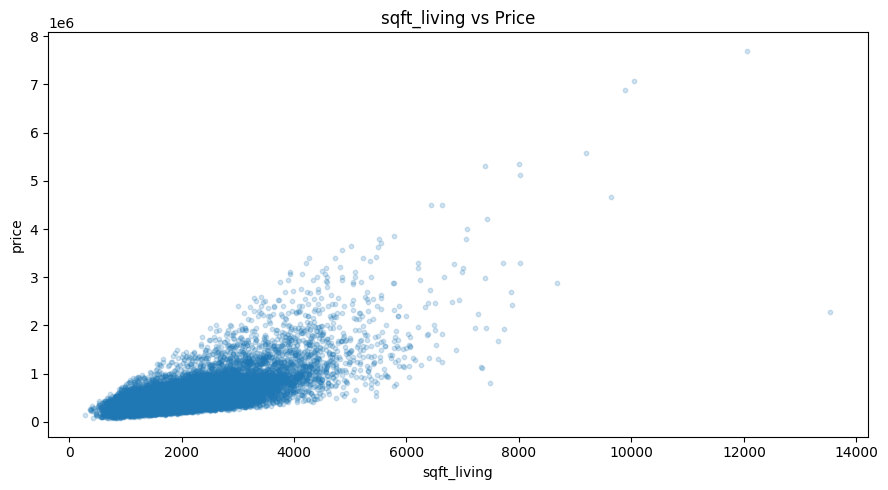

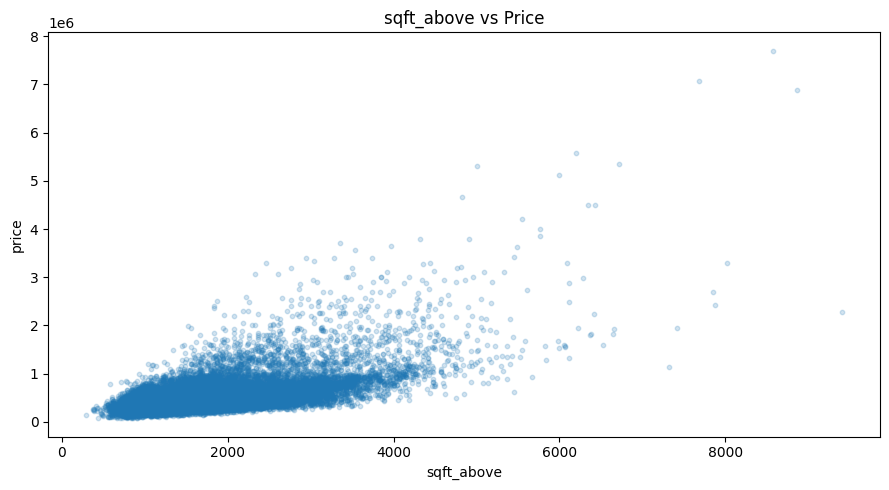

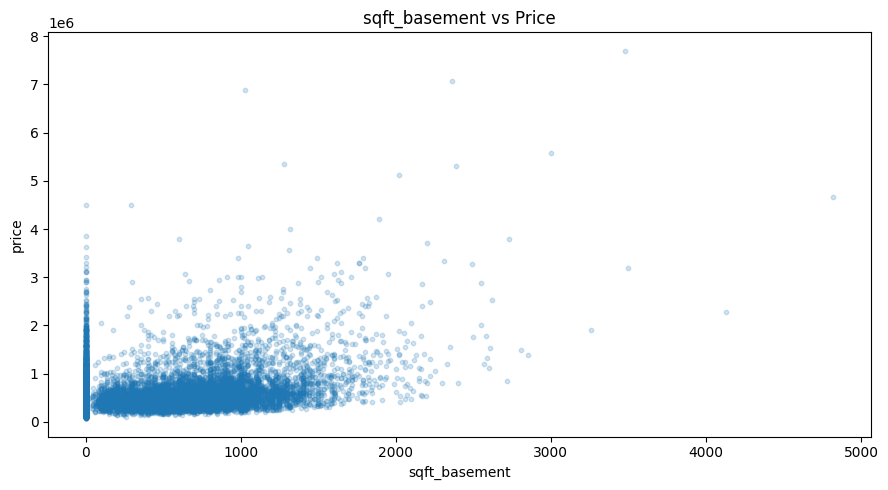

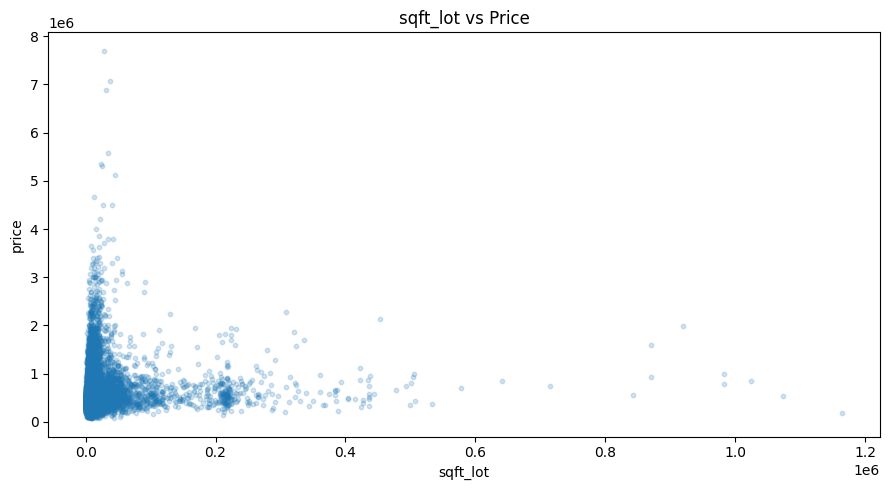

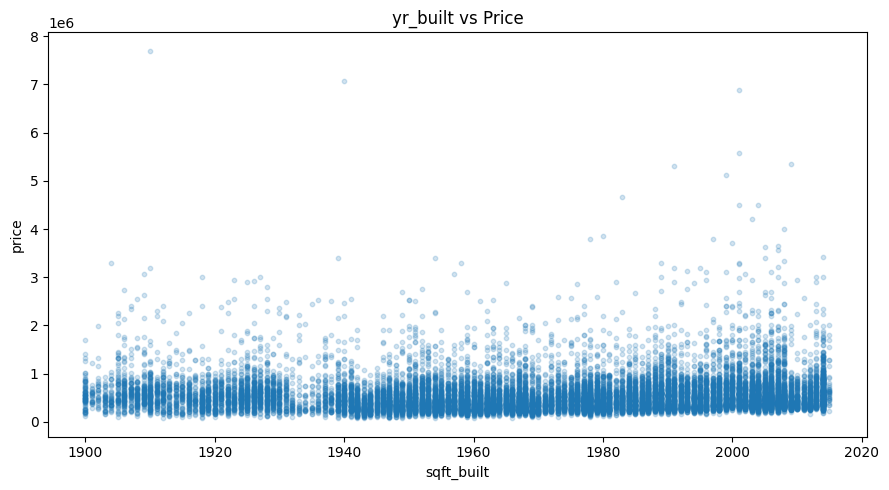

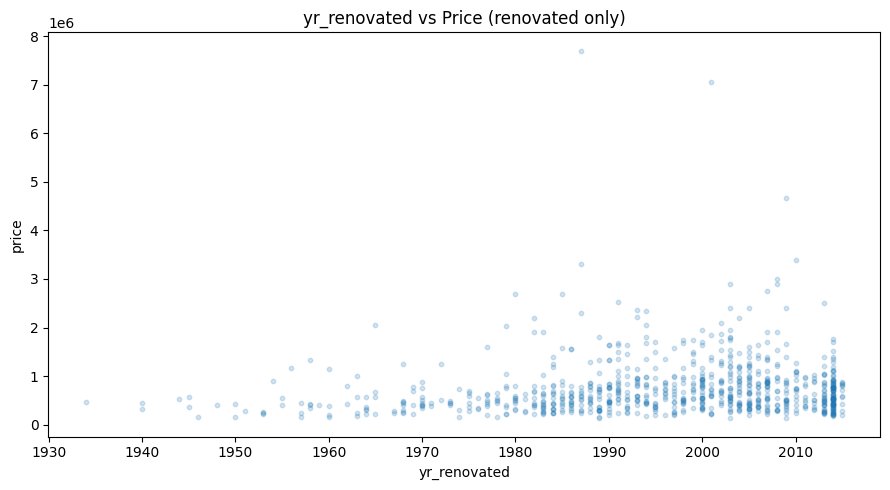

In [ ]:
#various scatter plots
plt.figure(figsize=(9, 5))
plt.scatter(housing["sqft_living"], housing["price"], alpha=0.2, s=10)
plt.title("sqft_living vs Price")
plt.xlabel("sqft_living")
plt.ylabel("price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
plt.scatter(housing["sqft_above"], housing["price"], alpha=0.2, s=10)
plt.title("sqft_above vs Price")
plt.xlabel("sqft_above")
plt.ylabel("price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
plt.scatter(housing["sqft_basement"], housing["price"], alpha=0.2, s=10)
plt.title("sqft_basement vs Price")
plt.xlabel("sqft_basement")
plt.ylabel("price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
plt.scatter(housing["sqft_lot"], housing["price"], alpha=0.2, s=10)
plt.title("sqft_lot vs Price")
plt.xlabel("sqft_lot")
plt.ylabel("price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
plt.scatter(housing["yr_built"], housing["price"], alpha=0.2, s=10)
plt.title("yr_built vs Price")
plt.xlabel("sqft_built")
plt.ylabel("price")
plt.tight_layout()
plt.show()

filtered = housing[housing["yr_renovated"] != 0]

plt.figure(figsize=(9, 5))
plt.scatter(filtered["yr_renovated"], filtered["price"], alpha=0.2, s=10)
plt.title("yr_renovated vs Price (renovated only)")
plt.xlabel("yr_renovated")
plt.ylabel("price")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3646149327.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=grades, showfliers=False)


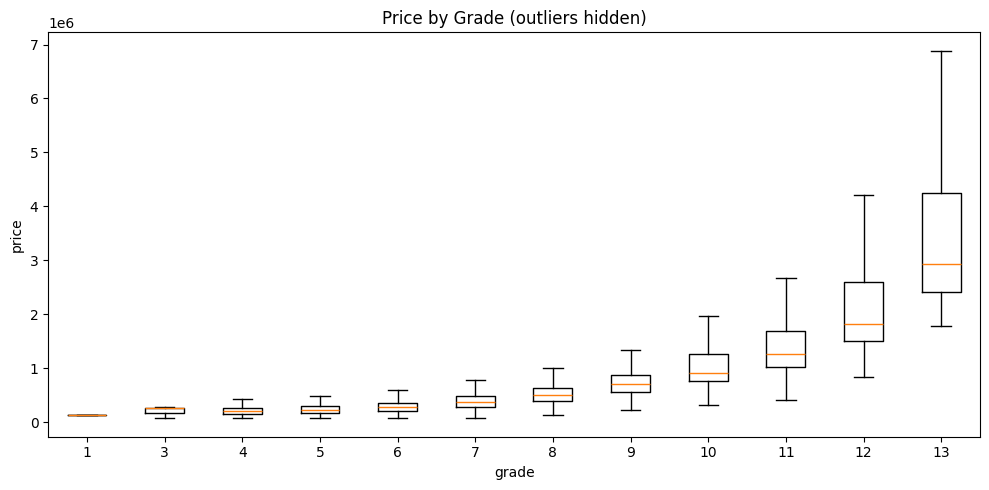

In [ ]:
col = "grade"
df_box = housing.dropna(subset=[col, "price"]).copy()

grades = np.sort(df_box[col].unique())
data = [df_box.loc[df_box[col] == g, "price"].values for g in grades]

plt.figure(figsize=(10, 5))
plt.boxplot(data, labels=grades, showfliers=False)
plt.title("Price by Grade (outliers hidden)")
plt.xlabel("grade")
plt.ylabel("price")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2232029547.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


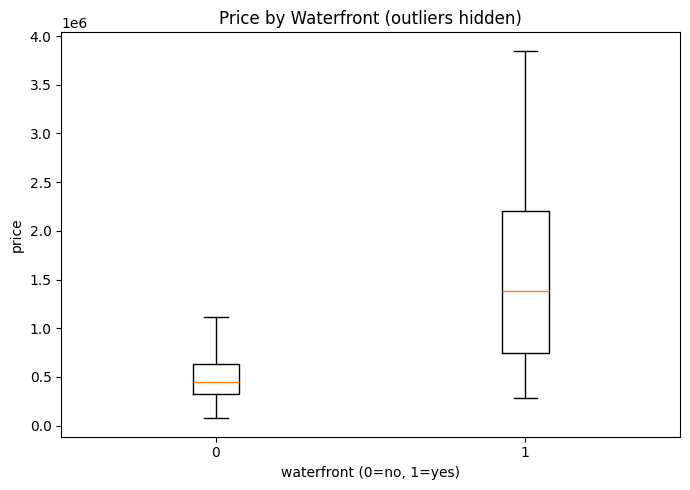

In [ ]:
col = "waterfront"
df_box = housing.dropna(subset=[col, "price"]).copy()

cats = np.sort(df_box[col].unique())
data = [df_box.loc[df_box[col] == c, "price"].values for c in cats]

plt.figure(figsize=(7, 5))
plt.boxplot(data, labels=cats, showfliers=False)
plt.title("Price by Waterfront (outliers hidden)")
plt.xlabel("waterfront (0=no, 1=yes)")
plt.ylabel("price")
plt.tight_layout()
plt.show()


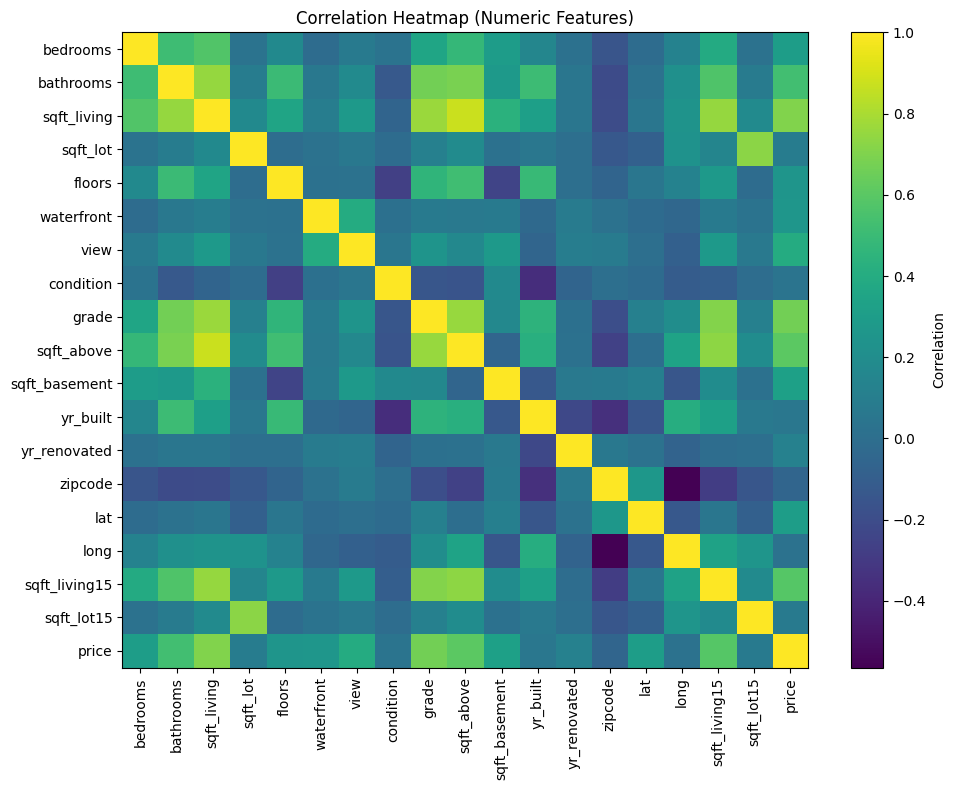

In [ ]:
# Keep numeric columns only
num_df = housing.select_dtypes(include=[np.number]).copy()

# Optionally remove columns you don't want in correlation (like ids)
for maybe in ["id"]:
    if maybe in num_df.columns:
        num_df = num_df.drop(columns=[maybe])

corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2687291317.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=neighborhoods, showfliers=False)


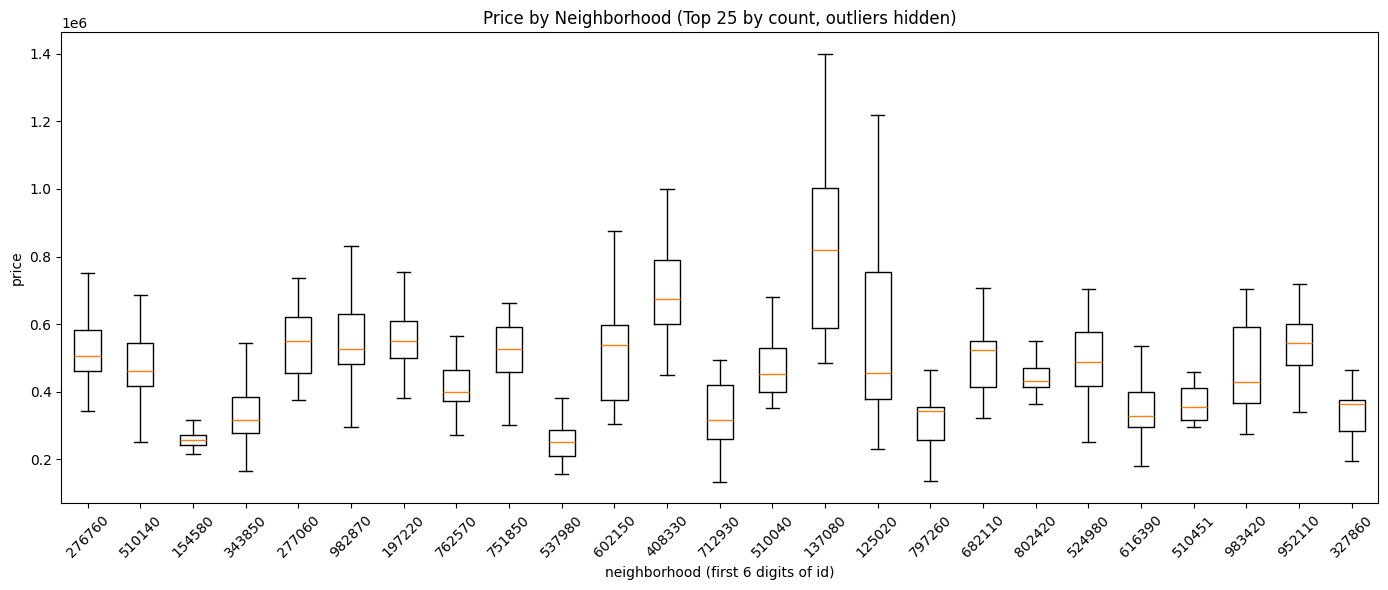

In [ ]:
# Drop rows missing what we need
housing_nb = housing.dropna(subset=["neighborhood", "price"]).copy()

top_n = 25

top_neighborhoods = housing_nb["neighborhood"].value_counts().head(top_n).index
df_top = housing_nb[housing_nb["neighborhood"].isin(top_neighborhoods)].copy()

# Keep neighborhoods ordered by frequency (most common first)
neighborhoods = list(top_neighborhoods)
data = [df_top.loc[df_top["neighborhood"] == n, "price"].values for n in neighborhoods]

plt.figure(figsize=(14, 6))
plt.boxplot(data, labels=neighborhoods, showfliers=False)
plt.title(f"Price by Neighborhood (Top {top_n} by count, outliers hidden)")
plt.xlabel("neighborhood (first 6 digits of id)")
plt.ylabel("price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()